In [1]:
!nvidia-smi

Fri Oct 31 20:01:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.listdir('/content/drive/MyDrive')

['Colab Notebooks',
 'Fiecare stea se luptă cu gravitația.docx',
 'admissionletter.pdf',
 'DSCF1654.JPG',
 'DSCF1660.JPG',
 'DSCF1655.JPG',
 'DSCF1666.JPG',
 'DSCF1668.JPG',
 'DSCF1669.JPG',
 'DSCF1672.JPG',
 'DSCF1673.JPG',
 'cv_2025.pdf',
 'constellation_dataset.zip',
 'best_constellation_model.pt',
 'processed_image_grayscale.jpg',
 'processed_image_scorpius.jpg',
 'sorted_data.zip']

In [5]:
!pip install torch torchvision timm Pillow scikit-learn matplotlib seaborn

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
zip_path = "/content/drive/MyDrive/sorted_data.zip"
extract_dir = "dataset"

print("Extracting dataset...")
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✓ Extracted to '{extract_dir}/'")
else:
    print(f"✓ Already extracted")

Extracting dataset...
✓ Extracted to 'dataset/'


In [14]:
data_dir = "dataset/sorted_data"
img_size = 224
batch_size = 16
num_epochs = 50
learning_rate = 1e-4
patience = 10  # Early stopping patience

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['damaged_bottle', 'dirty_bottle', 'notprimagass_bottle', 'ok_bottle']

print(f"Device: {device}")


Device: cuda


In [17]:
image_paths = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_idx)

print(f"\nTotal images: {len(image_paths)}")
for i, class_name in enumerate(classes):
    count = labels.count(i)
    print(f"  {class_name}: {count}")


Total images: 521
  damaged_bottle: 58
  dirty_bottle: 55
  notprimagass_bottle: 45
  ok_bottle: 363


In [18]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTrain: {len(train_paths)}, Val: {len(val_paths)}")


Train: 416, Val: 105


In [19]:
class GasTankDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [20]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
train_dataset = GasTankDataset(train_paths, train_labels, train_transform)
val_dataset = GasTankDataset(val_paths, val_labels, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
print("\nCreating model...")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


Creating model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [25]:
import copy

In [26]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0
best_model_wts = None
no_improve = 0

print("\nStarting training...")
for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels_batch in train_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels_batch.size(0)
        correct += predicted.eq(labels_batch).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * correct / total


    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels_batch)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels_batch.size(0)
            correct += predicted.eq(labels_batch).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}, Acc: {val_acc:.2f}%")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve = 0
    else:
        no_improve += 1


    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

#Save best model after training
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/drive/MyDrive/best_gas_tank_model.pth')
    print(f"\n✓ Best model saved to Google Drive (Val Acc: {best_val_acc:.2f}%)")

print(f"\nTraining complete! Best Val Acc: {best_val_acc:.2f}%")


Starting training...
Epoch 1/50
  Train Loss: 0.2561, Acc: 91.59%
  Val Loss:   0.3774, Acc: 88.57%
Epoch 2/50
  Train Loss: 0.1922, Acc: 93.51%
  Val Loss:   0.2516, Acc: 87.62%
Epoch 3/50
  Train Loss: 0.1439, Acc: 94.95%
  Val Loss:   0.3069, Acc: 89.52%
Epoch 4/50
  Train Loss: 0.1540, Acc: 94.95%
  Val Loss:   0.3545, Acc: 85.71%
Epoch 5/50
  Train Loss: 0.1132, Acc: 94.95%
  Val Loss:   0.5249, Acc: 82.86%
Epoch 6/50
  Train Loss: 0.1131, Acc: 96.39%
  Val Loss:   0.4782, Acc: 84.76%
Epoch 7/50
  Train Loss: 0.0450, Acc: 98.56%
  Val Loss:   0.5328, Acc: 84.76%
Epoch 8/50
  Train Loss: 0.0719, Acc: 98.32%
  Val Loss:   0.5181, Acc: 87.62%
Epoch 9/50
  Train Loss: 0.0648, Acc: 98.08%
  Val Loss:   0.5411, Acc: 90.48%
Epoch 10/50
  Train Loss: 0.0798, Acc: 96.88%
  Val Loss:   0.6727, Acc: 85.71%
Epoch 11/50
  Train Loss: 0.1302, Acc: 96.15%
  Val Loss:   0.4699, Acc: 85.71%
Epoch 12/50
  Train Loss: 0.0395, Acc: 99.04%
  Val Loss:   0.5166, Acc: 89.52%
Epoch 13/50
  Train Loss: 0

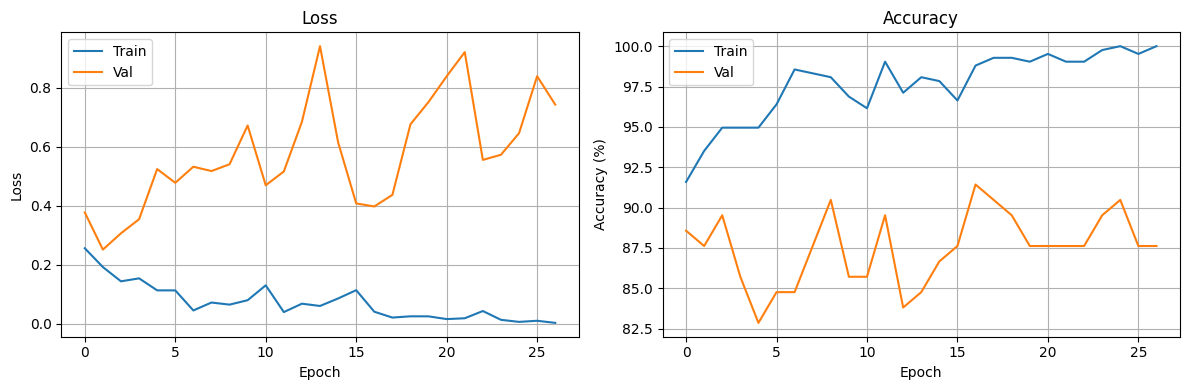

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train')
ax2.plot(val_accs, label='Val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
